# MIT XGBoost model (multiple class)
 As we concluded before, for MIT data, we apply the following preprocessing:   
resampling: Oversampling
rescaling: MinMax Scaler
 
If you don't have the original files: run the notebook `preprocessing_mit_multipleclass_minmax_oversampling.ipynb`      

Input file: (The preprocessed data)   
mitbih_train_multipleclass_minmax_oversampling.csv \
mitbih_test_multipleclass_minmax_oversampling.csv

Output:   
model_mit_multiple_raw_XGBoost.pkl  

In [1]:
import sys
import os 

data_path = ''
model_output_path = ''
# check if the enviorment is Google Colab 

if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install imbalanced-learn -q

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your google drive. 
    data_path = '/content/drive/MyDrive/Heartbeat_Project/'
    model_output_path = data_path

else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/processed/'
    model_output_path = '../models/'

Running on local environment
Current working directory: g:\Meine Ablage\heartbeat-analysis-ai\notebooks


# Read Data

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import numpy as np
import seaborn as sns
import pickle

RawFiles = dict({
    'train': data_path + 'mitbih_train_multipleclass_minmax_oversampling.csv',
    'test': data_path + 'mitbih_test_multipleclass_minmax_oversampling.csv'
})

OutputFiles = dict({
    'model': model_output_path +  'model_mit_multiple_raw_XGBoost.pkl',
})


train = pd.read_csv(RawFiles.get('train'),sep=',',header=0)
test = pd.read_csv(RawFiles.get('test'),sep=',',header=0)

y_train = train['target']
X_train = train.drop('target', axis=1)

y_test = test['target']
X_test = test.drop('target', axis=1)



In [3]:
# check if target has only 2 classes
y_train.value_counts()

target
0    72471
1    72471
2    72471
3    72471
Name: count, dtype: int64

In [4]:
# check if target has only 2 classes
y_test.value_counts()

target
0    18118
2     1448
1      556
3      162
Name: count, dtype: int64

# XGBoost Grid Search



c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:16:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:17:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:18:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not u

Best parameters: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 0.8}
Average F1 Score from Nested Cross-Validation: 0.8970


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:21:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


F1 score: 0.8885661271463959


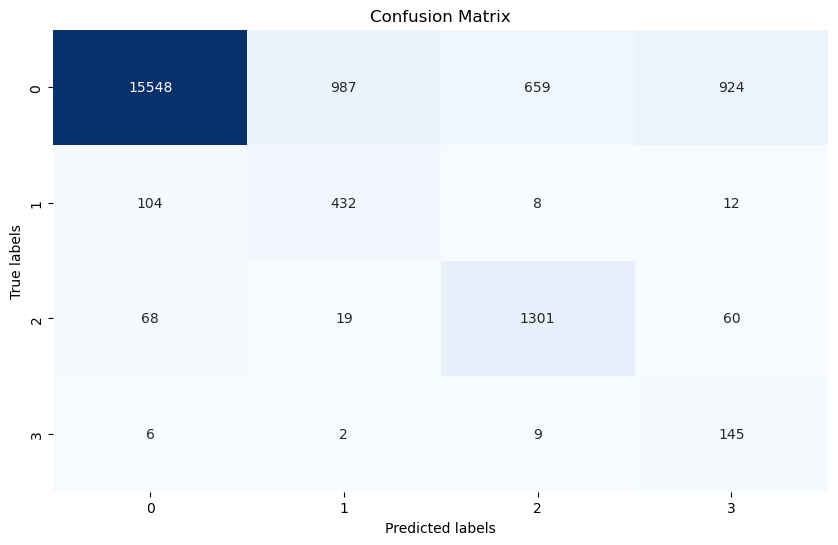

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92     18118
           1       0.30      0.78      0.43       556
           2       0.66      0.90      0.76      1448
           3       0.13      0.90      0.22       162

    accuracy                           0.86     20284
   macro avg       0.52      0.86      0.58     20284
weighted avg       0.94      0.86      0.89     20284



In [5]:
# XGBoost model with initial parameters
xgb = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42)

# Grid search parameters for XGBoost (simplified to avoid computational overhead)
grid_params = {
    'xgb__n_estimators': [100],  # Number of trees in the forest
    'xgb__max_depth': [3],  # Maximum depth of the tree
    'xgb__learning_rate': [0.1],  # Learning rate
    'xgb__subsample': [0.8],  # Subsample ratio of the training instances
    'xgb__colsample_bytree': [0.8],  # Subsample ratio of columns when constructing each tree
}

# Inner and outer cross-validation (for nested cross-validation)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Pipeline with XGBoost
pipeline = Pipeline([
    ('xgb', xgb)  
])

# Nested cross-validation with grid search
nested_scores = []

for train_index, test_index in outer_cv.split(X_train, y_train):
    X_train_inner, X_test_inner = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_inner, y_test_inner = y_train.iloc[train_index], y_train.iloc[test_index]

    # Grid search with cross-validation
    grid_search = GridSearchCV(pipeline, grid_params, cv=inner_cv, scoring='f1_weighted', n_jobs=-1)
    grid_search.fit(X_train_inner, y_train_inner)

    # Best model from the inner grid search
    best_model = grid_search.best_estimator_

    # Model on the outer test set
    y_pred = best_model.predict(X_test_inner)

    # F1 score (macro-averaged for multi-class)
    f1 = f1_score(y_test_inner, y_pred, average='macro')
    nested_scores.append(f1)

# Best hyperparameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Average F1 score from the nested cross-validation
print(f'Average F1 Score from Nested Cross-Validation: {np.mean(nested_scores):.4f}')

# Train the final model on the full training dataset
final_model = grid_search.best_estimator_
final_model.fit(X_train, y_train)

# Prediction on the test set
y_pred = final_model.predict(X_test)

# F1 score (macro-averaged)
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)



In [6]:
# Print the summary
print(f"Best parameters: {best_params}")
print(f"F1 score on the test set: {f1}")

Best parameters: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 0.8}
F1 score on the test set: 0.8885661271463959


### Save model

In [7]:
# Save model 
import pickle
# Save the model to a file
with open(OutputFiles.get('model'), 'wb') as model_file:
    pickle.dump(final_model, model_file)

In [8]:
from datetime import datetime
# Display the running time
print("Current time:", datetime.now())

Current time: 2024-12-11 09:22:05.364816
